In [1]:
# Importing all needed libraries
import numpy as np
import math
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram
from functools import reduce
import pandas as pd
from numba import jit,njit,vectorize

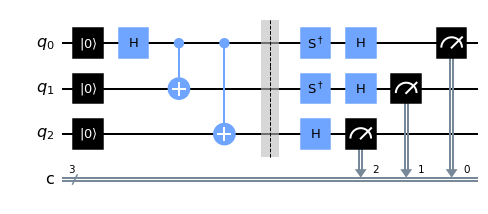

In [6]:
############################
#Circuit ONE
############################

#Call Aer's qasm_simulator
simulator = QasmSimulator()

###This is for 001 corr to 01

#Create a Quantum Circuit acting on the q register
circuit = QuantumCircuit(3,3)



###Initialize the in zero Q-State
circuit.reset(0)
circuit.reset(1)
circuit.reset(2)

#########Following build are 
#Add a H gate on qubit 0
circuit.h(0)

#Add a CX (CNOT) gate on control qubit 0 and target qubit 1
circuit.cx(0, 1)

circuit.cx(0,2)
for i in np.arange(3):
    circuit.barrier(i)


      #Map the quantum measurement to the classical bits
for i in np.arange(3):
    if i != 2:
        circuit.sdg(i)
    circuit.h(i)
    circuit.measure(i,i)
#circuit.measure([0,1], [0,1])
#circuit.measure(2,2)

#compile the circuit down to low-level QASM instructions
compiled_circuit = transpile(circuit, simulator)


#Draw the circuit
circuit.draw('mpl')

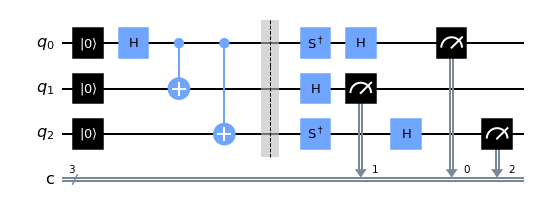

In [7]:
########################################
#Circuit TWO
########################################


###This is for 010 corr to 10
circuit2=QuantumCircuit(3,3)

###Initialize the in zero Q-State
circuit2.reset(0)
circuit2.reset(1)
circuit2.reset(2)

#########Following build are 
#Add a H gate on qubit 0
circuit2.h(0)

#Add a CX (CNOT) gate on control qubit 0 and target qubit 1
circuit2.cx(0, 1)
circuit2.cx(0,2)

for i in np.arange(3):
    circuit2.barrier(i) 
    
#Map the quantum measurement to the classical bits
for i in np.arange(3):
    ##This parts does the measurment 
    if i != 1:
        circuit2.sdg(i)
    circuit2.h(i)
    circuit2.measure(i,i)
    
#compile the circuit down to low-level QASM instructions
compiled_circuit2 = transpile(circuit2, simulator)

#Draw the circuit
circuit2.draw('mpl')

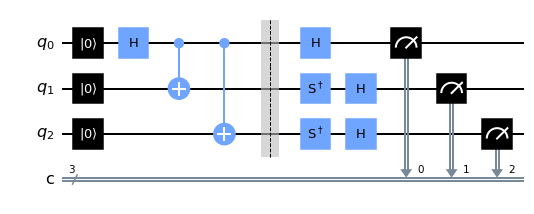

In [8]:
################################
#Circuit THREE
################################


###This is for 100 corr to 00


circuit3=QuantumCircuit(3,3)

###Initialize the in zero Q-State
circuit3.reset(0)
circuit3.reset(1)
circuit3.reset(2)

#########Following build are 
# Add a H gate on qubit 0
circuit3.h(0)

# Add a CX (CNOT) gate on control qubit 0 and target qubit 1
circuit3.cx(0, 1)
circuit3.cx(0,2)

for i in np.arange(3):
    circuit3.barrier(i)

# Map the quantum measurement to the classical bits
for i in np.arange(3):
    ##This parts does the measurment 
    if i != 0:
        circuit3.sdg(i)
    circuit3.h(i)
    circuit3.measure(i,i)
    
# compile the circuit down to low-level QASM instructions
compiled_circuit3 = transpile(circuit3, simulator)


# Draw the circuit
circuit3.draw('mpl')

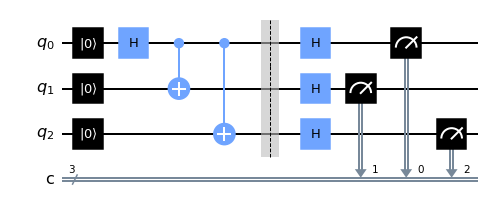

In [9]:
##################################
#Circuit FOUR
##################################


###This is for 111 corr to 11
####This circuit measure the GHZ state in y-basis
####Measurement done in y-basis if the input is 1

circuit4=QuantumCircuit(3,3)

###Initialize the in zero Q-State
circuit4.reset(0)
circuit4.reset(1)
circuit4.reset(2)

#########Following build are 
# Add a H gate on qubit 0
circuit4.h(0)

# Add a CX (CNOT) gate on control qubit 0 and target qubit 1
circuit4.cx(0, 1)
circuit4.cx(0,2)




for i in np.arange(3):
    circuit4.barrier(i)
    
# Map the quantum measurement to the classical bits
for i in np.arange(3):
    ##This parts does the measurment 
    circuit4.h(i)
    circuit4.measure(i,i)
    
# compile the circuit down to low-level QASM instructions
compiled_circuit4 = transpile(circuit4, simulator)

#count
# Draw the circuit
circuit4.draw('mpl')

In [ ]:
###########In this version I define everything as numpy func
import time
#from dask import dataframe as dd

##########
#Start timer
start_time = time.time()

#########
#Define AND for lists
def AND(x, y):
    return x&y

myAND = np.frompyfunc(AND, 2, 1)

###########This part takes RAW data and feeds it to round 1
bit_len=32 ########### This the compression factor
chunk_size=10**7
kkk=0  ## Chunk no. counter



for chunk in pd.read_csv('Input_file.dat',index_col=False,chunksize=chunk_size):
    input_=chunk.iloc[:,0]

    length=np.floor(len(input_)/bit_len)

    print(length)

    Out=[]
    k1=0
    k2=0
    k3=0
    k4=0

    job1=simulator.run(compiled_circuit,shots=(chunk_size),memory=True)
    result1=job1.result()
    rez1=np.array(result1.get_memory(compiled_circuit))



    job2=simulator.run(compiled_circuit2,shots=(chunk_size),memory=True)
    result2=job2.result()
    rez2=np.array(result2.get_memory(compiled_circuit2))



    job3=simulator.run(compiled_circuit3,shots=(chunk_size),memory=True)
    result3=job3.result()
    rez3=np.array(result3.get_memory(compiled_circuit3))


    job4=simulator.run(compiled_circuit4,shots=(chunk_size),memory=True)
    result4=job4.result()
    rez4=np.array(result4.get_memory(compiled_circuit4))



    for i in np.arange(length):
        ####This part divides data into 8-bit groups
        n=int(bit_len*i)
        n_=int(bit_len*(i+1))
        byte=np.array(input_[n:n_])
        A=[]
        B=[]

        
        for k in np.arange(bit_len/2):
            ind=int(2*k)
            ind_=int(2*(k+1))
            sub_bit=np.array(byte[ind:ind_])
            a=sub_bit[0]
            b=sub_bit[1]
  
            if np.array_equal(sub_bit,[0,1]):
                ###Take setting 001
                A.append(int(rez1[k1][0]))
                B.append(int(rez1[k1][1]))
                k1=k1+1
                
                
            elif np.array_equal(sub_bit,[1,0]):
                ###Take setting 010
                A.append(int(rez2[k2][0]))
                B.append(int(rez2[k2][1]))
                k2=k2+1
                
            elif np.array_equal(sub_bit,[0,0]):
                ###Take setting 100
                A.append(int(rez3[k3][0]))
                B.append(int(rez3[k3][1]))
                k3=k3+1
                  
            elif np.array_equal(sub_bit,[1,1]):
                ###Take setting 111
                A.append(int(rez4[k4][0]))
                B.append(int(rez4[k4][1]))
                k4=k4+1
        #print('A is ',A,'B is ',B)


        k_=myAND(A,B)
        jj=reduce(lambda x, y: x ^ y, k_)
        

        Out.append(jj)
          
    #print(Out)

    kkk=kkk+1
    df=pd.DataFrame(Out)
    df.to_csv('Output_file.dat',mode='a',index=False,header=False)
    print(kkk)
print("--- %s seconds ---" % (time.time() - start_time))

###################
##### Takes about 1400 sec for ~20MB
